In [ ]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats

In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
Average training label:  31.38551016671317
tensor([26], dtype=torch.uint8)


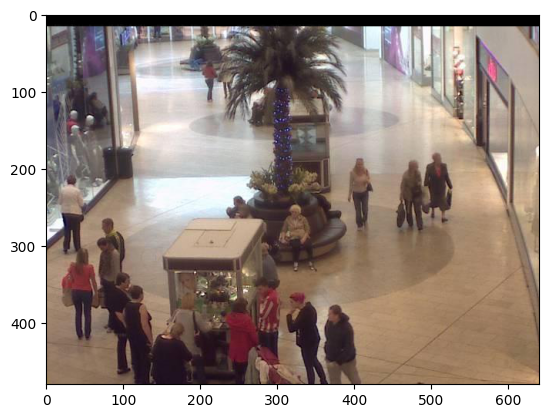

In [ ]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")
batch = 64

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=0)

print("Path to dataset files:", path)
labels_total = 0
for _, labels in train_loader:
  labels_total += torch.mean(labels.float()).item()

print("Average training label: ",(labels_total * batch)/len(train_data))

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 =  nn.Conv2d(32, 64, 5)
        self.bn3 = nn.BatchNorm2d(64)

        self.adaptive_pool = nn.AdaptiveMaxPool2d((12, 12))

        self.fc1 = nn.Linear(64*12*12, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 60)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def plot_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [ ]:
epochs = 50
def train(network, device):
  test_acc = np.zeros(epochs)
  train_acc = np.zeros(epochs)
  for epoch in range(epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
          for j in range(inputs.shape[0]):
              labels_2d[j, labels[j].int()] = 1
          labels_2d = labels_2d.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = network(inputs.permute(0, 3, 2, 1).float())
          loss = criterion(outputs.float(), labels_2d.float())
          loss.backward()
          optimizer.step()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          running_acc += torch.mean(torch.abs(predicted.float() - labels)).item() * labels.size(0)
          running_loss += loss.item()
      # train_acc[epoch] = running_loss/total
      train_acc[epoch] = running_acc/total
      print(running_loss)
      total = 0
      running_acc = 0.0
      with torch.no_grad():
          for data in test_loader:
              images, labels = data

              images = images.to(device)
              labels = labels.to(device)

              outputs = net(images.permute(0, 3, 2, 1).float())
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)


              error = torch.mean(torch.abs(predicted.float() - labels)).item()
              running_acc += error * labels.size(0)
      test_acc[epoch] = running_acc/total
  plot_graphs("Simple CNN", train_acc, test_acc, "CNN_Plots")

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

cpu


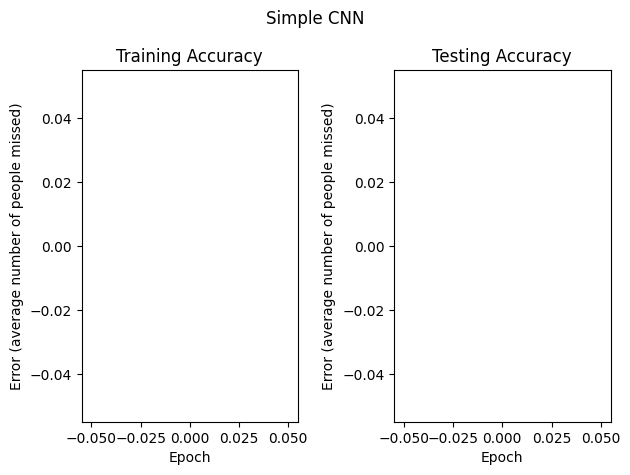

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

Predicted:  tensor(25) tensor(2) tensor(33) tensor(2)
Truth:  tensor([32], dtype=torch.uint8) tensor([35], dtype=torch.uint8) tensor([28], dtype=torch.uint8) tensor([24], dtype=torch.uint8)


ValueError: `x` and `y` must have length at least 2.

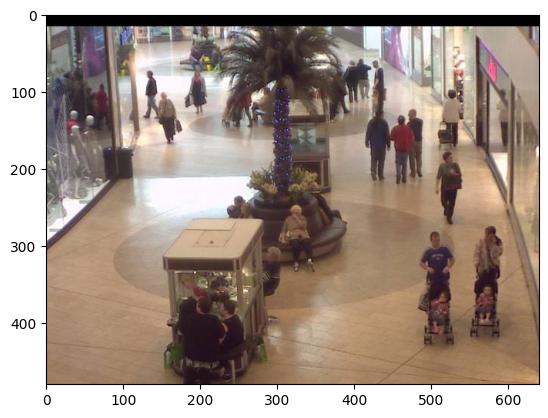

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))
# imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

predicted_data = np.zeros(0)
ground_truth_data = np.zeros(0)

total = 0.0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.permute(0, 3, 2, 1).float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        np.append(predicted_data, predicted.numpy())
        np.append(ground_truth_data, labels.numpy())

        error = torch.mean(torch.abs(predicted.float() - labels))
        batch_size = labels.size(0)
        total_error += error * batch_size

correlation, pvalue = stats.pearsonr(predicted_data, ground_truth_data)

plt.scatter(predicted_data, ground_truth_data)
plt.show()

print("P-Value:", pvalue)

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))

In [ ]:
print(predicted_data)